<center><h1>Análisis de Series Temporales</h1></center>
<center><h2>Laboratorio 1: Forecasting</h2></center>
<br>

## Grupo
* Martín Hunziker
* Ramiro Caro
* Claudio Sarate


In [1]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rcParams['figure.figsize'] = [8, 6]

In [4]:
data=pd.read_csv('datasets/Telefonia_movil.csv', parse_dates=True, dayfirst=True, thousands='.')

In [5]:
data["Periodo"] = data["Año"].map(str) + "-" + (data["Trimestre"]*3-2).map(str)

In [6]:
data.Periodo.head()

0     2013-1
1     2013-4
2     2013-7
3    2013-10
4     2014-1
Name: Periodo, dtype: object

In [7]:
data.Periodo = pd.to_datetime(data.Periodo)

In [8]:
data.index = data.Periodo

In [9]:
data.index = data.index.to_period(freq='Q') # converting the index to quarterly period instead of dates

In [10]:
data.tail()

,Año,Trimestre,Minutos pospago salientes (miles),Minutos prepago salientes (miles),Total de minutos salientes (miles),Periodo
Periodo,,,,,,
2018Q1,2018,1,13423580,5850985,19274565,2018-01-01
2018Q2,2018,2,14240217,6027374,20267591,2018-04-01
2018Q3,2018,3,14574305,6108477,20682782,2018-07-01
2018Q4,2018,4,14915060,6613685,21528745,2018-10-01
2019Q1,2019,1,13937271,6427084,20364355,2019-01-01


In [11]:
data.columns

Index(['Año', 'Trimestre', 'Minutos pospago salientes (miles)',
       'Minutos prepago salientes (miles)',
       'Total de minutos salientes (miles)', 'Periodo'],
      dtype='object')

For univariate time series modelling, it is better to work with a pandas series rather than dataframe. 

In [12]:
y1 = data['Minutos pospago salientes (miles)']
y2 = data['Minutos prepago salientes (miles)']

In [13]:
y1.head()

Periodo
2013Q1     8785943
2013Q2     9512689
2013Q3    10315484
2013Q4     9809515
2014Q1    10128751
Freq: Q-DEC, Name: Minutos pospago salientes (miles), dtype: int64

In [14]:
y2.head()

Periodo
2013Q1    6582117
2013Q2    7108640
2013Q3    7335154
2013Q4    6250549
2014Q1    5799223
Freq: Q-DEC, Name: Minutos prepago salientes (miles), dtype: int64

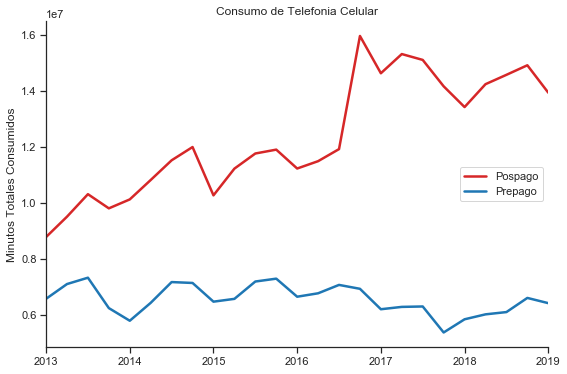

In [15]:
fig, ax= plt.subplots(figsize=(9,6))
y1.plot(color=red, linewidth=2.5, linestyle="-", label="Pospago")
y2.plot(color=blue, linewidth=2.5, linestyle="-", label="Prepago")
ax.set_xlabel('')
ax.set_ylabel('Minutos Totales Consumidos')
ax.set_title('Consumo de Telefonia Celular')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
plt.legend(loc='center right')
sns.despine()
plt.show()

In [16]:
y1.describe()


count    2.500000e+01
mean     1.235930e+07
std      2.085582e+06
min      8.785943e+06
25%      1.082146e+07
50%      1.190507e+07
75%      1.424022e+07
max      1.596076e+07
Name: Minutos pospago salientes (miles), dtype: float64

In [17]:
y2.describe()

count    2.500000e+01
mean     6.562909e+06
std      5.168604e+05
min      5.380710e+06
25%      6.250549e+06
50%      6.579819e+06
75%      7.077838e+06
max      7.335154e+06
Name: Minutos prepago salientes (miles), dtype: float64

## Random walk


In [18]:
h = 4
test1=pd.period_range(start=y1.index[-1]+1, periods=h, freq='Q')
pred1=pd.Series(np.repeat(y1.iloc[-1], h), index=test1) # the forecast repeats the last observed values h times
pred1

2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int64

In [19]:
h = 4
test2=pd.period_range(start=y2.index[-1]+1, periods=h, freq='Q')
pred2=pd.Series(np.repeat(y2.iloc[-1], h), index=test1) # the forecast repeats the last observed values h times
pred2

2019Q2    6427084
2019Q3    6427084
2019Q4    6427084
2020Q1    6427084
Freq: Q-DEC, dtype: int64

Estimamos el desvio estandard de los errores.

In [20]:
resid1=y1-y1.shift(1) # the shift lags the series by one period
sigma1 = resid1.std()
round(sigma1,3)

1111026.926

In [21]:
resid2=y2-y2.shift(1) # the shift lags the series by one period
sigma2 = resid2.std()
round(sigma2,3)

510832.977

### Estimamos el intervalo de predicción. 
#### Serie Postpago

In [22]:
intv1 = pd.concat([pred1-stats.norm.ppf(0.975)*sigma1*np.sqrt(np.arange(1,h+1)),
                   pred1+stats.norm.ppf(0.975)*sigma1*np.sqrt(np.arange(1,h+1))], axis=1)
intv1.round(3)

,0,1
2019Q2,1.175970e+07,1.611484e+07
2019Q3,1.085772e+07,1.701682e+07
2019Q4,1.016560e+07,1.770894e+07
2020Q1,9.582125e+06,1.829242e+07


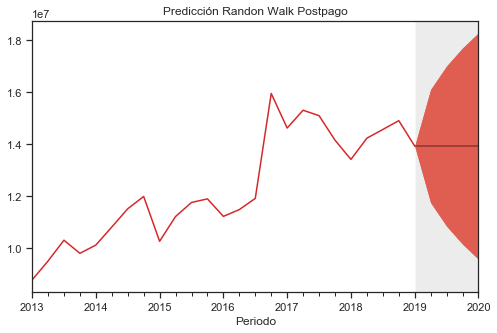

In [23]:
from plotting import fanchart
 
point_pred1 = (intv1[0]+intv1[1])/2

fig, ax = fanchart(y1,point_pred1,intv1,intv1,intv1 )
ax.set_title('Predicción Randon Walk Postpago')

plt.show()

#### Serie Prepago

In [24]:
intv2 = pd.concat([pred2-stats.norm.ppf(0.975)*sigma2*np.sqrt(np.arange(1,h+1)),
                   pred2+stats.norm.ppf(0.975)*sigma2*np.sqrt(np.arange(1,h+1))], axis=1)
intv2.round(3)


,0,1
2019Q2,5425869.763,7428298.237
2019Q3,5011153.247,7843014.753
2019Q4,4692930.072,8161237.928
2020Q1,4424655.526,8429512.474


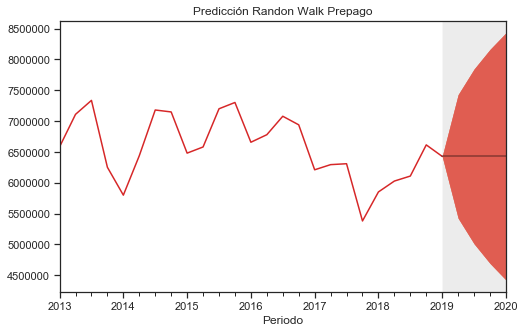

In [25]:
point_pred2 = (intv2[0]+intv2[1])/2

fig, ax = fanchart(y2,point_pred2,intv2,intv2,intv2 )
ax.set_title('Predicción Randon Walk Prepago')

plt.show()

## Simple exponential smoothing


In [26]:
model_ses1 = sm.tsa.SimpleExpSmoothing(y1).fit()
fitted_ses1 = model_ses1.fittedvalues
model_ses1.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,28393933896676.352
Optimized:,True,AIC,697.958
Trend:,None,BIC,700.396
Seasonal:,None,AICC,699.958
Seasonal Periods:,None,Date:,"Thu, 12 Sep 2019"
Box-Cox:,False,Time:,21:48:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7870587,alpha,True
initial_level,8.7859e+06,l.0,True


In [27]:
model_ses2 = sm.tsa.SimpleExpSmoothing(y2).fit()
fitted_ses2 = model_ses2.fittedvalues
model_ses2.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,5830154997664.624
Optimized:,True,AIC,658.380
Trend:,None,BIC,660.817
Seasonal:,None,AICC,660.380
Seasonal Periods:,None,Date:,"Thu, 12 Sep 2019"
Box-Cox:,False,Time:,21:48:38
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4343574,alpha,True
initial_level,6.7577e+06,l.0,True


In [28]:
mse_ses1 = sm.tools.eval_measures.mse(y1,fitted_ses1)
mse_ses2 = sm.tools.eval_measures.mse(y2,fitted_ses2)

print(' Predicción de las muestras:')
print(' MSE_Postpago               {}'.format(mse_ses1*(1e-6)))
print(' MSE_Prepago                {}'.format(mse_ses2*(1e-6)))


 Predicción de las muestras:
 MSE_Postpago               1135757.3558670538
 MSE_Prepago                233206.19990658495


Cálculo de AIC y BIC

In [29]:
N = len(y1)
loglik_ses1=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses1)
aic_ses1=-2*loglik_ses1+2*3
bic_ses1=-2*loglik_ses1+np.log(N)*3

loglik_ses2=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_ses2)
aic_ses2=-2*loglik_ses2+2*3
bic_ses2=-2*loglik_ses2+np.log(N)*3

print(' Postpago:')
print(' Log-likelihood    %.3f' % (loglik_ses1))
print(' AIC               {0:.3f}'.format(aic_ses1))
print(' BIC               {0:.3f}'.format(bic_ses1))

print(' Prepago:')
print(' Log-likelihood    %.3f' % (loglik_ses2))
print(' AIC               {0:.3f}'.format(aic_ses2))
print(' BIC               {0:.3f}'.format(bic_ses2))




 Postpago:
 Log-likelihood    -382.452
 AIC               770.905
 BIC               774.562
 Prepago:
 Log-likelihood    -362.663
 AIC               731.327
 BIC               734.983


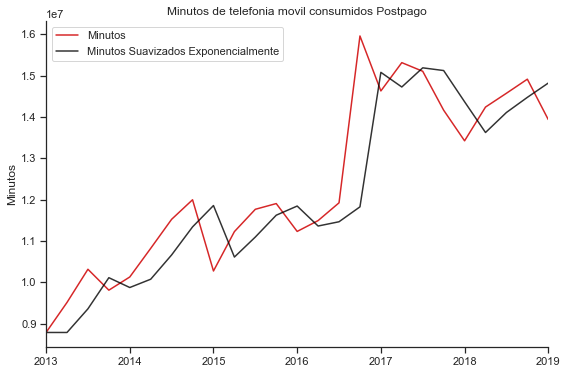

In [30]:
fig, ax= plt.subplots(figsize=(9,6))
y1.plot(color=red, label='Minutos')
fitted_ses1.plot(color='black', label='Minutos Suavizados Exponencialmente', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos')
ax.set_title('Minutos de telefonia movil consumidos Postpago')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

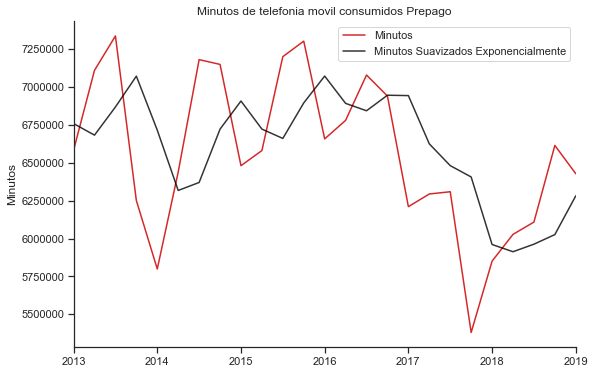

In [31]:
fig, ax= plt.subplots(figsize=(9,6))
y2.plot(color=red, label='Minutos')
fitted_ses2.plot(color='black', label='Minutos Suavizados Exponencialmente', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Minutos')
ax.set_title('Minutos de telefonia movil consumidos Prepago')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Diagnóstico de los modelos

Se realizará el diagnóstico de los modelo utilizando: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.


In [32]:
resid1=y1-fitted_ses1 # model_ses.resid isn't a panda.Series, so no index, no plot
resid2=y2-fitted_ses2

### Residual Plot

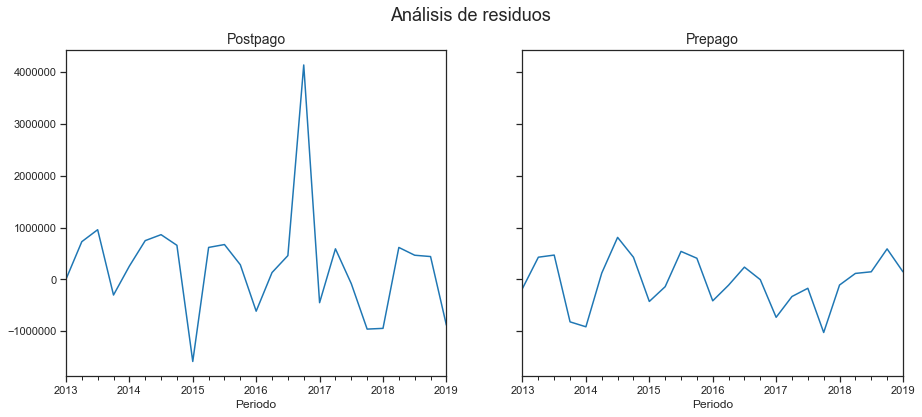

In [33]:

fig = plt.figure()
fig.set_size_inches(15, 6)
fig.suptitle('Análisis de residuos',fontsize=18)

ax1 = plt.subplot(121)
resid1.plot(color=blue)
ax1.set_title("Postpago", {'fontsize': 14})

ax2 = plt.subplot(122, sharey=ax1)
resid2.plot(color=blue)
ax2.set_title("Prepago", {'fontsize': 14})
plt.setp(ax2.get_yticklabels(), visible=False) # Use this to hide axes labels

plt.show()

Los residuos de las dos series no se muestran como ruido blanco ya que presentan un comportamiento cíclico. Esto nos indica que están faltando componentes de los datos para predecir por parte del modelo planteado.

### Histograma y kernel density estimation de los residuos

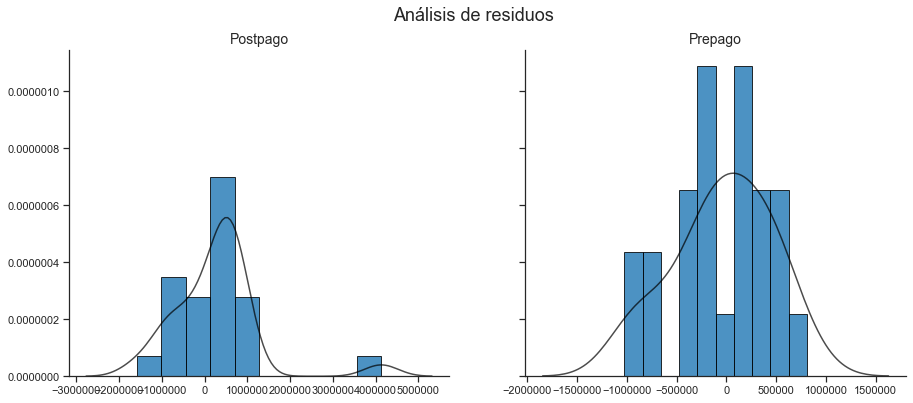

In [34]:
fig = plt.figure()
fig.set_size_inches(15, 6)
fig.suptitle('Análisis de residuos',fontsize=18)
ax1 = plt.subplot(121)
sns.distplot(resid1, ax=ax1, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},bins=10,  
                 kde_kws={'color': 'black', 'alpha': 0.7})
sns.despine()
ax1.set_title("Postpago", {'fontsize': 14})

ax2 = plt.subplot(122, sharey=ax1)
sns.distplot(resid2, ax=ax2, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': blue},bins=10,  
                 kde_kws={'color': 'black', 'alpha': 0.7})
sns.despine()
ax2.set_title("Prepago", {'fontsize': 14})
plt.setp(ax2.get_yticklabels(), visible=False) # Use this to hide axes labels

plt.show()

## Validación del modelo

Para validar el modelo se realizará una proyección con ambos modelos

### Postpago

In [35]:
# Real time forecasting - use it as a template - expanding window

validation=y1['2017Q1':].index # the validation period is Q1 2004 onwards
start = y1.index.get_loc('2017Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y1)):
    
    actual.append(y1.iloc[i]) # actual value
    
    pred1.append(y1.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y1.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
pd.options.display.float_format = '{:,.2f}'.format
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

,RW,SES,Actual
Periodo,,,
2018Q1,"14,164,552.00","14,372,950.26","13,423,580.00"
2018Q2,"13,423,580.00","13,590,289.24","14,240,217.00"
2018Q3,"14,240,217.00","14,110,313.68","14,574,305.00"
2018Q4,"14,574,305.00","14,480,809.77","14,915,060.00"
2019Q1,"14,915,060.00","14,831,774.84","13,937,271.00"


In [36]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,"786,660.91","266,525.25"
SES,"787,677.78","266,371.90"


El modelo RW genera una proyección más adecuada de acuerdo con RMSE, sin embargo de acuerdo al indicador SE es apenas mejor la proyección de SES. 

### Prepago

In [37]:

validation=y2['2017Q1':].index # the validation period is Q1 2004 onwards
start = y2.index.get_loc('2017Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y2)):
    
    actual.append(y2.iloc[i]) # actual value
    
    pred1.append(y2.iloc[i-1]) # random walk forecast
    
    model = sm.tsa.SimpleExpSmoothing(y2.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
pd.options.display.float_format = '{:,.2f}'.format
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

,RW,SES,Actual
Periodo,,,
2018Q1,"5,380,710.00","6,652,112.01","5,850,985.00"
2018Q2,"5,850,985.00","5,890,438.84","6,027,374.00"
2018Q3,"6,027,374.00","5,961,204.75","6,108,477.00"
2018Q4,"6,108,477.00","6,027,325.20","6,613,685.00"
2019Q1,"6,613,685.00","6,267,373.38","6,427,084.00"


In [38]:
table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,"465,233.08","163,251.30"
SES,"633,172.54","198,986.85"


El modelo RW genera una proyección más adecuada

## Proyección

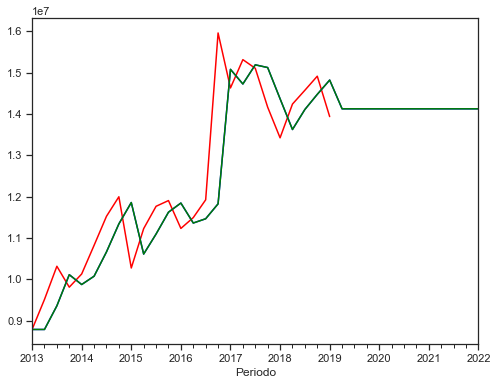

In [39]:
h=12
w=h*10
data = y1
model = sm.tsa.SimpleExpSmoothing
pred_index = y1.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');

In this case, **statsmodels** doesn't provide interval forecast

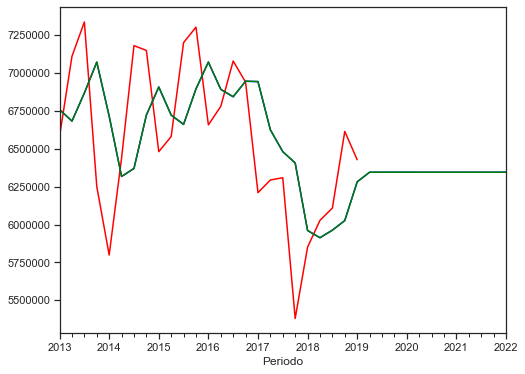

In [40]:
h=12
w=h*10
data = y2
model = sm.tsa.SimpleExpSmoothing
pred_index = y2.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='red');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='green');